<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024-3_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Metabo2024-3 Multiclass**



In [ ]:
# 必要ライブラリ読み込み
!pip install timm==0.5.4 --q #timmのバージョンが違うとうまくstate dictできないので注意！！！
import random
import timm
import copy
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm.scheduler import CosineLRScheduler
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
%matplotlib inline


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 17.3 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cuda:0


<ipython-input-1-9a7943c16507>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
original_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
original_df = pd.read_csv(original_csv_path)

# Load the provided metabo_disease.csv file again
disease_csv_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/metabo_disease.csv'
disease_df = pd.read_csv(disease_csv_path)

# Filter the disease_df to get only rows where reason is "AH" or "Blur"
#exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]
exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]

# Extract the ids (filenames) from ah_blur_df that match the 'AH' or 'Blur' criteria
ah_blur_ids = exclude_df['id'].tolist()

# Now remove these filenames from comparison_df
cleaned_df = original_df[~original_df['filename'].isin(ah_blur_ids)]
len(cleaned_df)

4618

In [ ]:
cleaned_df.head()

,filename,age,AC,SBP,DBP,HDLC,TG,BS,METS
0,img75151275_00_1R.jpg,62,98.2,147,93,56,152,96,1
1,img96940480_00_1R.jpg,65,81.3,168,91,60,124,81,0
2,img15900654_00_1R.jpg,65,96.8,127,86,47,171,104,1
5,img44396554_00_1R.jpg,64,95.3,167,96,43,308,160,1
6,img26138665_00_1R.jpg,65,85.7,165,71,72,186,115,1


#**Finetune Metabo prediction model from age estimation dataset**

cuda:0


<ipython-input-7-bfadbcbea8e8>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-7-bfadbcbea8e8>:126: FutureWar

Epoch 1/200
Train Loss: 22.2327, Acc: 0.4862, Prec: 0.4862, Rec: 1.0000, F1: 0.6543, AUC: 0.5000
Val Loss: 22.0416, Acc: 0.5000, Prec: 0.5000, Rec: 1.0000, F1: 0.6667, AUC: 0.5000
Epoch duration: 1067.01 seconds
Best model updated
Current learning rate: 0.000020
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 2/200
Train Loss: 2.5369, Acc: 0.5555, Prec: 0.5388, Rec: 0.5952, F1: 0.5656, AUC: 0.5642
Val Loss: 0.7075, Acc: 0.5422, Prec: 0.5248, Rec: 0.8939, F1: 0.6613, AUC: 0.6180
Epoch duration: 226.23 seconds
Best model updated
Current learning rate: 0.000040
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 3/200
Train Loss: 0.6989, Acc: 0.5799, Prec: 0.5693, Rec: 0.5579, F1: 0.5636, AUC: 0.6094
Val Loss: 0.6758, Acc: 0.5693, Prec: 0.6270, Rec: 0.3420, F1: 0.4426, AUC: 0.6319
Epoch duration: 226.31 seconds
Best model updated
Current learning rate: 0.000060
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 4/200
Train Loss: 0.6914, Acc: 0.5874, Prec: 0.5786, Rec: 0.5573, F1: 0.5678, AUC: 0.6207
Val Loss: 0.7766, Acc: 0.5184, Prec: 0.5095, Rec: 0.9870, F1: 0.6721, AUC: 0.6411
Epoch duration: 226.49 seconds
Best model not updated
Current learning rate: 0.000080
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 5/200
Train Loss: 0.7108, Acc: 0.5774, Prec: 0.5668, Rec: 0.5551, F1: 0.5609, AUC: 0.6077
Val Loss: 0.6655, Acc: 0.6180, Prec: 0.5886, Rec: 0.7835, F1: 0.6722, AUC: 0.6366
Epoch duration: 225.50 seconds
Best model updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 6/200
Train Loss: 0.6886, Acc: 0.6121, Prec: 0.6019, Rec: 0.5969, F1: 0.5994, AUC: 0.6439
Val Loss: 0.7357, Acc: 0.5173, Prec: 0.8077, Rec: 0.0455, F1: 0.0861, AUC: 0.6393
Epoch duration: 225.49 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 7/200
Train Loss: 0.6956, Acc: 0.5953, Prec: 0.5873, Rec: 0.5635, F1: 0.5752, AUC: 0.6324
Val Loss: 0.6703, Acc: 0.6039, Prec: 0.5873, Rec: 0.6991, F1: 0.6383, AUC: 0.6286
Epoch duration: 225.68 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 8/200
Train Loss: 0.6914, Acc: 0.5966, Prec: 0.5850, Rec: 0.5863, F1: 0.5857, AUC: 0.6362
Val Loss: 0.6687, Acc: 0.6017, Prec: 0.5874, Rec: 0.6840, F1: 0.6320, AUC: 0.6275
Epoch duration: 225.63 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 9/200
Train Loss: 0.6918, Acc: 0.5877, Prec: 0.5779, Rec: 0.5640, F1: 0.5709, AUC: 0.6245
Val Loss: 0.6724, Acc: 0.5898, Prec: 0.5759, Rec: 0.6818, F1: 0.6244, AUC: 0.6234
Epoch duration: 225.27 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 10/200
Train Loss: 0.7005, Acc: 0.5915, Prec: 0.5810, Rec: 0.5729, F1: 0.5770, AUC: 0.6196
Val Loss: 0.6637, Acc: 0.6050, Prec: 0.6052, Rec: 0.6039, F1: 0.6046, AUC: 0.6383
Epoch duration: 225.59 seconds
Best model updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 11/200
Train Loss: 0.6533, Acc: 0.6340, Prec: 0.6257, Rec: 0.6153, F1: 0.6204, AUC: 0.6846
Val Loss: 0.6659, Acc: 0.6136, Prec: 0.6012, Rec: 0.6753, F1: 0.6361, AUC: 0.6427
Epoch duration: 226.30 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 12/200
Train Loss: 0.6696, Acc: 0.6221, Prec: 0.6110, Rec: 0.6130, F1: 0.6120, AUC: 0.6675
Val Loss: 0.7854, Acc: 0.5898, Prec: 0.5565, Rec: 0.8853, F1: 0.6834, AUC: 0.6248
Epoch duration: 225.41 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 13/200
Train Loss: 0.6619, Acc: 0.6308, Prec: 0.6229, Rec: 0.6097, F1: 0.6162, AUC: 0.6738
Val Loss: 0.6737, Acc: 0.5974, Prec: 0.5787, Rec: 0.7165, F1: 0.6402, AUC: 0.6338
Epoch duration: 225.20 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 14/200
Train Loss: 0.6540, Acc: 0.6275, Prec: 0.6190, Rec: 0.6080, F1: 0.6135, AUC: 0.6817
Val Loss: 0.7044, Acc: 0.5400, Prec: 0.6529, Rec: 0.1710, F1: 0.2710, AUC: 0.6449
Epoch duration: 225.41 seconds
Best model not updated
Current learning rate: 0.000100
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 15/200
Train Loss: 0.6599, Acc: 0.6275, Prec: 0.6204, Rec: 0.6024, F1: 0.6113, AUC: 0.6707
Val Loss: 0.6757, Acc: 0.5866, Prec: 0.6064, Rec: 0.4935, F1: 0.5442, AUC: 0.6449
Epoch duration: 225.19 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 16/200
Train Loss: 0.6592, Acc: 0.6270, Prec: 0.6189, Rec: 0.6058, F1: 0.6123, AUC: 0.6758
Val Loss: 0.6675, Acc: 0.5909, Prec: 0.5792, Rec: 0.6645, F1: 0.6190, AUC: 0.6360
Epoch duration: 225.63 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 17/200
Train Loss: 0.6769, Acc: 0.6172, Prec: 0.6096, Rec: 0.5913, F1: 0.6003, AUC: 0.6657
Val Loss: 0.6742, Acc: 0.5942, Prec: 0.6079, Rec: 0.5303, F1: 0.5665, AUC: 0.6369
Epoch duration: 225.51 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 18/200
Train Loss: 0.6752, Acc: 0.6110, Prec: 0.5993, Rec: 0.6030, F1: 0.6012, AUC: 0.6566
Val Loss: 0.6665, Acc: 0.5974, Prec: 0.6037, Rec: 0.5671, F1: 0.5848, AUC: 0.6422
Epoch duration: 225.95 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 19/200
Train Loss: 0.6439, Acc: 0.6416, Prec: 0.6301, Rec: 0.6364, F1: 0.6332, AUC: 0.6932
Val Loss: 0.6774, Acc: 0.5985, Prec: 0.5829, Rec: 0.6926, F1: 0.6330, AUC: 0.6333
Epoch duration: 226.09 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-bfadbcbea8e8>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa

Epoch 20/200
Train Loss: 0.6576, Acc: 0.6297, Prec: 0.6205, Rec: 0.6136, F1: 0.6170, AUC: 0.6820
Val Loss: 0.7922, Acc: 0.5162, Prec: 0.7273, Rec: 0.0519, F1: 0.0970, AUC: 0.6477
Epoch duration: 225.56 seconds
Best model not updated
Current learning rate: 0.000099
----------------------------------------
Early stopping triggered


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Accuracy: 0.6050
Final Precision: 0.6052
Final Recall: 0.6039
Final F1 Score: 0.6046
Final AUC: 0.6383


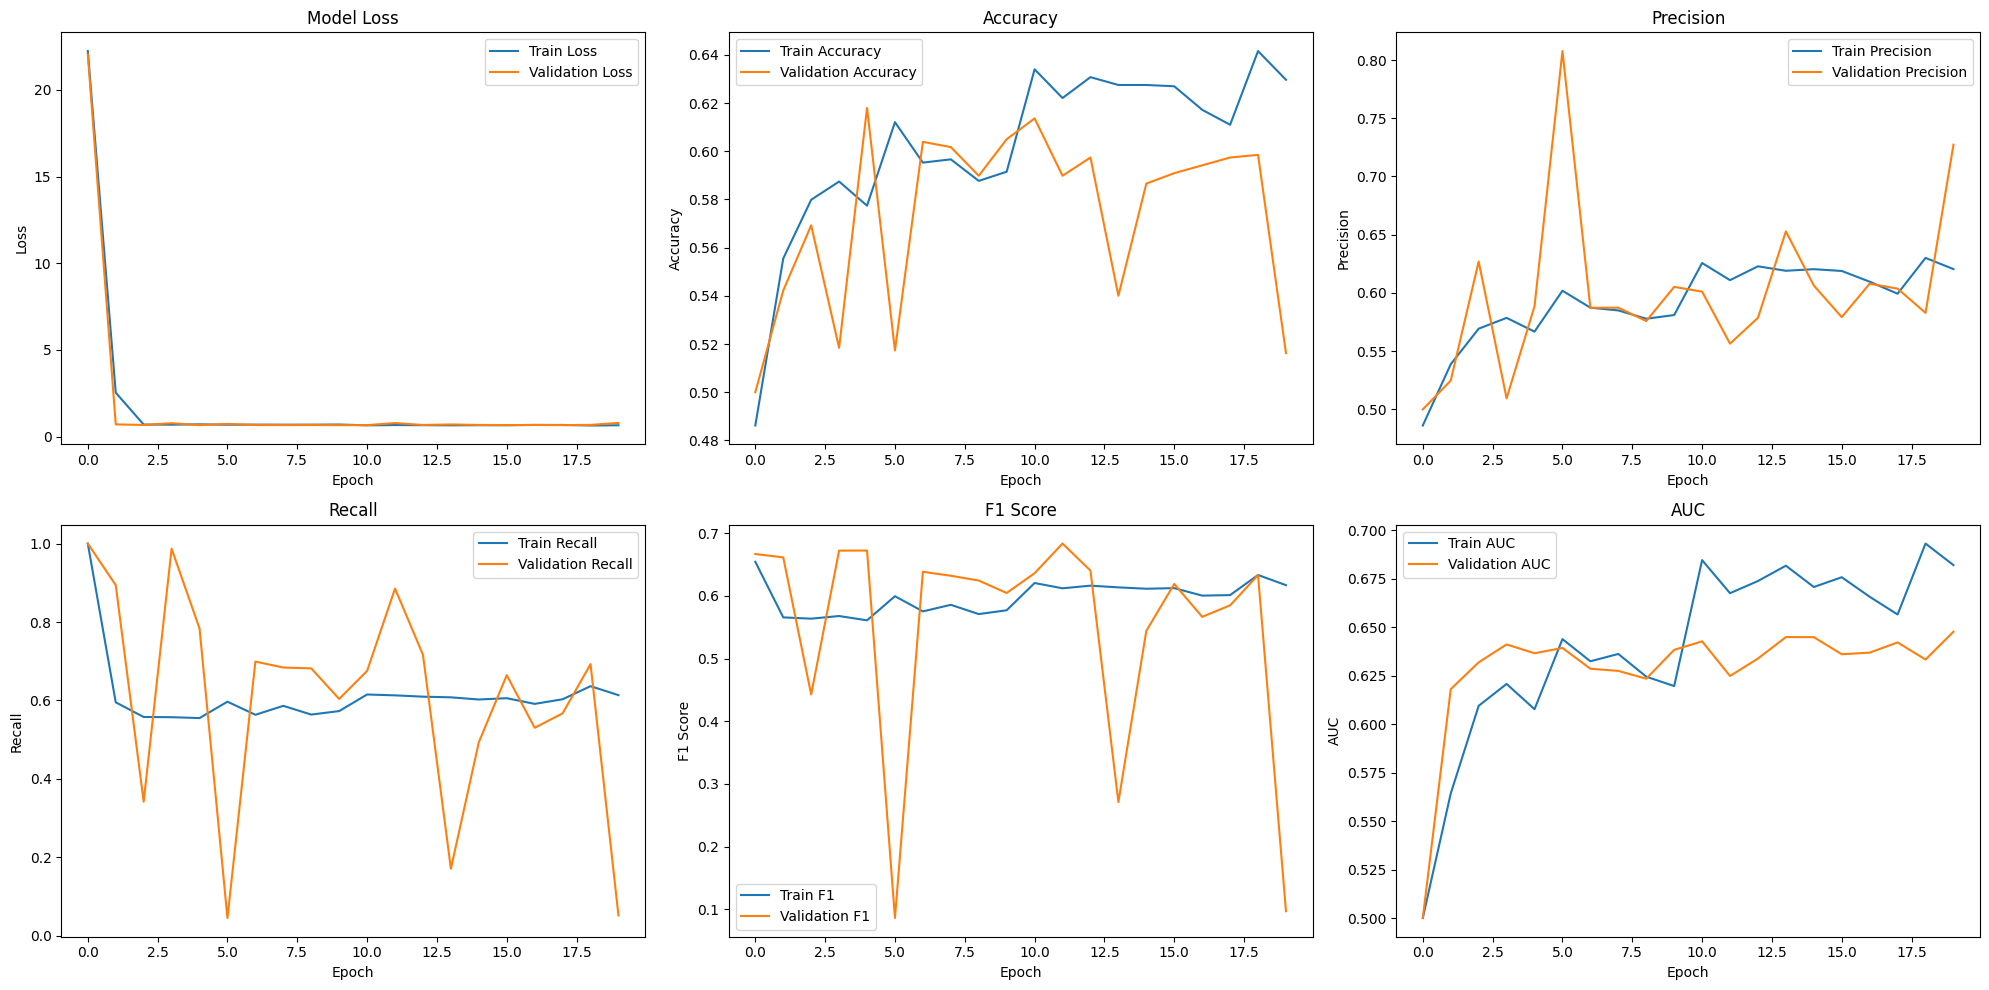

In [ ]:
import os
import random
import copy
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# CosineLRSchedulerのインポート（必要に応じて適切なライブラリを使用してください）
# 例として、timmライブラリを使用します
# pip install timm
import timm
from timm.scheduler.cosine_lr import CosineLRScheduler

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラム

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# cleaned_df の準備
# cleaned_df は既に用意されている前提です。以下は例です。
# cleaned_df = pd.read_csv('path_to_cleaned_df.csv')
# cleaned_df['METS'] = cleaned_df['METS'].apply(lambda x: 1 if x == 'yes' else 0)

# cleaned_df が既に適切に前処理されていることを確認してください
full_dataset = FundusDataset(cleaned_df, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)


# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))

# 損失関数と最適化手法の定義
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


# CosineLRSchedulerの設定
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

scaler = torch.cuda.amp.GradScaler()

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数の定義
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)  # shape: [batch, 1]
        inputs = inputs.to(memory_format=torch.channels_last)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs).squeeze(1)  # shape: [batch]
            loss = criterion(outputs, targets.squeeze(1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    all_preds_binary = [1 if p >= 0.5 else 0 for p in all_predictions]
    accuracy = accuracy_score(all_targets, all_preds_binary)
    precision = precision_score(all_targets, all_preds_binary, zero_division=0)
    recall = recall_score(all_targets, all_preds_binary, zero_division=0)
    f1 = f1_score(all_targets, all_preds_binary, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_predictions)
    except ValueError:
        auc = float('nan')  # クラスが一方のみの場合

    return epoch_loss, accuracy, precision, recall, f1, auc

# 評価関数の定義
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets.squeeze(1))

            running_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(torch.sigmoid(outputs).cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    all_preds_binary = [1 if p >= 0.5 else 0 for p in all_predictions]
    accuracy = accuracy_score(all_targets, all_preds_binary)
    precision = precision_score(all_targets, all_preds_binary, zero_division=0)
    recall = recall_score(all_targets, all_preds_binary, zero_division=0)
    f1 = f1_score(all_targets, all_preds_binary, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_predictions)
    except ValueError:
        auc = float('nan')  # クラスが一方のみの場合

    return epoch_loss, accuracy, precision, recall, f1, auc

# トレーニングループの定義
early_stopping = EarlyStopping(patience=patience)
history = {
    'train_loss': [], 'train_accuracy': [], 'train_precision': [],
    'train_recall': [], 'train_f1': [], 'train_auc': [],
    'val_loss': [], 'val_accuracy': [], 'val_precision': [],
    'val_recall': [], 'val_f1': [], 'val_auc': [],
    'lr': []
}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc, train_prec, train_rec, train_f1, train_auc = train(
        model, train_loader, criterion, optimizer, device, scaler
    )
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # 履歴の記録
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_precision'].append(train_prec)
    history['train_recall'].append(train_rec)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)

    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)

    # Early Stopping
    is_best = early_stopping(val_loss, model)

    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    # エポックごとの統計情報の表示
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, "
          f"Rec: {train_rec:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
          f"Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs).squeeze(1)
        preds = torch.sigmoid(outputs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 最終指標の計算
all_preds_binary = [1 if p >= 0.5 else 0 for p in all_preds]
final_accuracy = accuracy_score(all_labels, all_preds_binary)
final_precision = precision_score(all_labels, all_preds_binary, zero_division=0)
final_recall = recall_score(all_labels, all_preds_binary, zero_division=0)
final_f1 = f1_score(all_labels, all_preds_binary, zero_division=0)
try:
    final_auc = roc_auc_score(all_labels, all_preds)
except ValueError:
    final_auc = float('nan')

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")
print(f"Final AUC: {final_auc:.4f}")

# 訓練結果のグラフ表示
plt.figure(figsize=(20, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(2, 3, 3)
plt.plot(history['train_precision'], label='Train Precision')
plt.plot(history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 3, 4)
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# F1 Score
plt.subplot(2, 3, 5)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# AUC
plt.subplot(2, 3, 6)
plt.plot(history['train_auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import os

# モデルの保存先パスを設定
save_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/multiclass/simple_finetuning.pth"

# パスが存在することを確認し、必要に応じてディレクトリを作成
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# モデルの状態辞書を保存
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully to {save_path}")

Model saved successfully to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/multiclass/simple_finetuning.pth


## **Multiclass finetuning**

### Phase 1

In [ ]:
import os
import random
import copy
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# CosineLRSchedulerのインポート（必要に応じて適切なライブラリを使用してください）
# 例として、timmライブラリを使用します
# pip install timm
import timm
from timm.scheduler.cosine_lr import CosineLRScheduler

import os

# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
original_csv_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
original_df = pd.read_csv(original_csv_path)

# Load the provided metabo_disease.csv file again
disease_csv_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/metabo_disease.csv'
disease_df = pd.read_csv(disease_csv_path)

# Filter the disease_df to get only rows where reason is "AH" or "Blur"
#exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]
exclude_df = disease_df[disease_df['reason'].isin(['AH', 'Blur', 'ERM', "Hemorrhage", "Coagulation", "VO", "Degeneration", "AMD", "CRA", "Drusen"])]

# Extract the ids (filenames) from ah_blur_df that match the 'AH' or 'Blur' criteria
ah_blur_ids = exclude_df['id'].tolist()

# Now remove these filenames from comparison_df
cleaned_df = original_df[~original_df['filename'].isin(ah_blur_ids)]
len(cleaned_df)

4618

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

import timm
from timm.scheduler.cosine_lr import CosineLRScheduler

# CosineLRSchedulerのインポート（必要に応じて適切なライブラリを使用してください）
# 例として、timmライブラリを使用します
# pip install timm
import timm
from timm.scheduler.cosine_lr import CosineLRScheduler

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Training settings
num_epochs = 200
patience = 10
seed = 42
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_whole_384px"

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# トレーニングと検証の分割
train_df, val_df = train_test_split(
    cleaned_df, test_size=0.2, random_state=seed, shuffle=True, stratify=cleaned_df['METS']
)

# Tabular特徴量の列名（例）
tabular_features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']

# スケーラーの初期化とフィッティング（トレーニングデータのみ）
scaler = StandardScaler()
train_df[tabular_features] = scaler.fit_transform(train_df[tabular_features])

# 検証データにも同じスケーラーを適用
val_df[tabular_features] = scaler.transform(val_df[tabular_features])

### Tabularを含むデータセット
class FundusDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, use_tabular=True, tabular_features=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.use_tabular = use_tabular
        self.tabular_features = tabular_features

        if self.use_tabular and self.tabular_features is not None:
            self.tabular_data = self.data[self.tabular_features].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラム

        if self.transform:
            image = self.transform(image)

        if self.use_tabular and self.tabular_features is not None:
            tabular = torch.tensor(self.tabular_data[idx])
        else:
            tabular = None  # Tabularデータを使用しない場合

        return image, label, tabular



# トレーニング用のデータ変換
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用のデータ変換
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Tabular特徴量の指定
tabular_features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']

# トレーニング用データセット（Tabularデータを使用）
train_dataset = FundusDataset(
    dataframe=train_df,
    img_dir=img_dir,
    transform=transform_train,
    use_tabular=True,
    tabular_features=tabular_features
)

# 検証用データセット（Tabularデータを使用）
val_dataset = FundusDataset(
    dataframe=val_df,
    img_dir=img_dir,
    transform=transform_val,
    use_tabular=True,  # 第1フェーズでは検証でもTabularデータを使用
    tabular_features=tabular_features
)

# データローダーの作成
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True
)


###カスタムモデルの定義
class FundusModel(nn.Module):
    def __init__(self, image_model, tabular_dim=7, num_classes=1):
        super(FundusModel, self).__init__()
        self.image_model = image_model
        in_features = self.image_model.head.in_features  # 画像モデルの出力特徴量数を取得

        # タブularデータ用の全結合層
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )

        # 画像特徴とタブular特徴を結合した後の最終分類層
        self.final_fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular=None):
        # 画像特徴の抽出
        img_features = self.image_model.forward_features(image)
        img_features = self.image_model.global_pool(img_features)
        img_features = img_features.view(img_features.size(0), -1)  # [batch_size, in_features]

        if tabular is not None:
            # タブularデータの処理
            tab_features = self.tabular_fc(tabular)  # [batch_size, 128]
            # 画像特徴とタブular特徴の結合
            combined = torch.cat((img_features, tab_features), dim=1)  # [batch_size, in_features + 128]
        else:
            # タブularデータがない場合はゼロベクトルを結合
            combined = torch.cat((img_features, torch.zeros(img_features.size(0), 128).to(image.device)), dim=1)

        # 最終分類層
        out = self.final_fc(combined)
        return out



# モデルの初期化
# 事前学習モデルの読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=True)

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")
model = model.to(device)

# 学習済みモデルの重みをロード（アーキテクチャが一致していることを確認）
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
model.load_state_dict(torch.load(model_path, map_location=device))



# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


# 事前学習済みモデルの読み込み済みをカスタムモデルに組み込む
fundus_model = FundusModel(image_model=model, tabular_dim=len(tabular_features), num_classes=1)
fundus_model = fundus_model.to(device)



import torch.optim as optim
from timm.scheduler.cosine_lr import CosineLRScheduler

# 損失関数
criterion = nn.BCEWithLogitsLoss()

# 最適化手法
optimizer = optim.AdamW(fundus_model.parameters(), lr=1e-4, weight_decay=1e-4)

# CosineLRSchedulerの設定
num_epochs = 200
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

# AMP用のスケーラー
scaler = torch.cuda.amp.GradScaler()



import copy

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    for inputs, targets, tabular in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
        tabular = tabular.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs, tabular).squeeze(1)
            loss = criterion(outputs, targets.squeeze(1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    all_preds_binary = [1 if p >= 0.5 else 0 for p in all_predictions]
    accuracy = accuracy_score(all_targets, all_preds_binary)
    precision = precision_score(all_targets, all_preds_binary, zero_division=0)
    recall = recall_score(all_targets, all_preds_binary, zero_division=0)
    f1 = f1_score(all_targets, all_preds_binary, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_predictions)
    except ValueError:
        auc = float('nan')  # クラスが一方のみの場合

    return epoch_loss, accuracy, precision, recall, f1, auc

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets, tabular in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
            tabular = tabular.to(device)
            inputs = inputs.to(memory_format=torch.channels_last)

            outputs = model(inputs, tabular).squeeze(1)
            loss = criterion(outputs, targets.squeeze(1))

            running_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(torch.sigmoid(outputs).cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    all_preds_binary = [1 if p >= 0.5 else 0 for p in all_predictions]
    accuracy = accuracy_score(all_targets, all_preds_binary)
    precision = precision_score(all_targets, all_preds_binary, zero_division=0)
    recall = recall_score(all_targets, all_preds_binary, zero_division=0)
    f1 = f1_score(all_targets, all_preds_binary, zero_division=0)
    try:
        auc = roc_auc_score(all_targets, all_predictions)
    except ValueError:
        auc = float('nan')  # クラスが一方のみの場合

    return epoch_loss, accuracy, precision, recall, f1, auc



import time
import copy

# Early Stopping と履歴の初期化
early_stopping = EarlyStopping(patience=10)
history = {
    'train_loss': [], 'train_accuracy': [], 'train_precision': [],
    'train_recall': [], 'train_f1': [], 'train_auc': [],
    'val_loss': [], 'val_accuracy': [], 'val_precision': [],
    'val_recall': [], 'val_f1': [], 'val_auc': [],
    'lr': []
}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # トレーニングフェーズ
    train_loss, train_acc, train_prec, train_rec, train_f1, train_auc = train(
        fundus_model, train_loader, criterion, optimizer, device, scaler
    )

    # 検証フェーズ
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(
        fundus_model, val_loader, criterion, device
    )

    # 学習率スケジューラーのステップ
    scheduler.step(epoch + 1)

    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # 履歴の記録
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_precision'].append(train_prec)
    history['train_recall'].append(train_rec)
    history['train_f1'].append(train_f1)
    history['train_auc'].append(train_auc)

    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)

    # Early Stopping のチェック
    is_best = early_stopping(val_loss, fundus_model)

    if early_stopping.best_model is not None:
        fundus_model.load_state_dict(early_stopping.best_model)

    # エポックごとの統計情報の表示
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, "
          f"Rec: {train_rec:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
          f"Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最良モデルの保存（第1フェーズ）
torch.save(fundus_model.state_dict(), '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/multiclass/multiclass_phase1.pth')


使用デバイス: cuda:0


<ipython-input-19-593a3236679f>:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


cuda:0


<ipython-input-19-593a3236679f>:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Phase 2

In [ ]:
# ファインチューニング用のトレーニングデータセット（タブularデータを使用）
train_dataset_ft = FundusDataset(
    dataframe=train_df,
    img_dir=img_dir,
    transform=transform_train,
    use_tabular=True,
    tabular_features=tabular_features
)

# ファインチューニング用の検証データセット（タブularデータを使用しない）
val_dataset_ft = FundusDataset(
    dataframe=val_df,
    img_dir=img_dir,
    transform=transform_val,
    use_tabular=False,  # 検証時にはタブularデータを使用しない
    tabular_features=None
)

# データローダーの再作成
train_loader_ft = DataLoader(
    train_dataset_ft, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)
val_loader_ft = DataLoader(
    val_dataset_ft, batch_size=8, shuffle=False, num_workers=4, pin_memory=True
)


# 第1フェーズの最良モデルをロード
fundus_model_ft = FundusModel(image_model=model, tabular_dim=len(tabular_features), num_classes=1)
fundus_model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/multiclass/multiclass_phase1.pth', map_location=device))
fundus_model_ft = fundus_model_ft.to(device)
fundus_model_ft.train()

# 損失関数は同じ
criterion_ft = nn.BCEWithLogitsLoss()

# 最適化手法（学習率を低く設定）
optimizer_ft = optim.AdamW(fundus_model_ft.parameters(), lr=1e-5, weight_decay=1e-4)

# CosineLRSchedulerの再設定
scheduler_ft = CosineLRScheduler(
    optimizer_ft,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=5,
    warmup_lr_init=1e-7,
    warmup_prefix=True
)

# AMP用のスケーラー
scaler_ft = torch.cuda.amp.GradScaler()


# Early Stopping と履歴の初期化
early_stopping_ft = EarlyStopping(patience=10)
history_ft = {
    'train_loss': [], 'train_accuracy': [], 'train_precision': [],
    'train_recall': [], 'train_f1': [], 'train_auc': [],
    'val_loss': [], 'val_accuracy': [], 'val_precision': [],
    'val_recall': [], 'val_f1': [], 'val_auc': [],
    'lr': []
}

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # トレーニングフェーズ
    train_loss, train_acc, train_prec, train_rec, train_f1, train_auc = train(
        fundus_model_ft, train_loader_ft, criterion_ft, optimizer_ft, device, scaler_ft
    )

    # 検証フェーズ（タブularデータを使用しない）
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(
        fundus_model_ft, val_loader_ft, criterion_ft, device
    )

    # 学習率スケジューラーのステップ
    scheduler_ft.step(epoch + 1)

    current_lr = optimizer_ft.param_groups[0]['lr']
    history_ft['lr'].append(current_lr)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # 履歴の記録
    history_ft['train_loss'].append(train_loss)
    history_ft['train_accuracy'].append(train_acc)
    history_ft['train_precision'].append(train_prec)
    history_ft['train_recall'].append(train_rec)
    history_ft['train_f1'].append(train_f1)
    history_ft['train_auc'].append(train_auc)

    history_ft['val_loss'].append(val_loss)
    history_ft['val_accuracy'].append(val_acc)
    history_ft['val_precision'].append(val_prec)
    history_ft['val_recall'].append(val_rec)
    history_ft['val_f1'].append(val_f1)
    history_ft['val_auc'].append(val_auc)

    # Early Stopping のチェック
    is_best_ft = early_stopping_ft(val_loss, fundus_model_ft)

    if early_stopping_ft.best_model is not None:
        fundus_model_ft.load_state_dict(early_stopping_ft.best_model)

    # エポックごとの統計情報の表示
    print(f"Fine-Tuning Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, "
          f"Rec: {train_rec:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
          f"Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best_ft else 'not updated'}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    if early_stopping_ft.early_stop:
        print("Early stopping triggered during fine-tuning")
        break

# 最良モデルの保存（第2フェーズ）
torch.save(fundus_model_ft.state_dict(), '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/multiclass/multiclass_phase2.pth')
